<a href="https://colab.research.google.com/github/bysliu/DATA205/blob/main/data205_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LSTM
Long Short-Term Memory

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load data
collison_df = pd.read_csv('Merged_Collison_Data.csv', parse_dates=['Crash Date/Time'])

# Filter years
years_to_include = [2020, 2021, 2022, 2023, 2024, 2025]
lstm_2020_to_2025 = collison_df[collison_df['Year'].isin(years_to_include)].copy()

# Ensure Crash Date/Time is datetime
lstm_2020_to_2025['Crash Date/Time'] = pd.to_datetime(lstm_2020_to_2025['Crash Date/Time'])

# Group by month
monthly_crashes = lstm_2020_to_2025['Crash Date/Time'].dt.to_period('M').value_counts().sort_index()
monthly_crashes = monthly_crashes.to_timestamp().reset_index()
monthly_crashes.columns = ['date', 'crashes']
monthly_crashes.set_index('date', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(monthly_crashes[['crashes']])

# Create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 12
X, y = create_sequences(scaled_data, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, y, epochs=50, batch_size=12, verbose=1)

# Predict next 12 months
last_sequence = scaled_data[-window_size:]
predictions = []
current_sequence = last_sequence.copy()

for _ in range(12):
    current_input = current_sequence.reshape((1, window_size, 1))
    next_pred = model.predict(current_input, verbose=0)
    predictions.append(next_pred[0, 0])
    current_sequence = np.append(current_sequence[1:], next_pred, axis=0)

# Convert predictions back to original scale
predicted_crashes = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# Create future dates
last_date = monthly_crashes.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')

forecast_df = pd.DataFrame({
    'date': future_dates,
    'predicted_crashes': predicted_crashes
})
forecast_df.set_index('date', inplace=True)




<ipython-input-10-e191433fc107>:9: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  collison_df = pd.read_csv('Merged_Collison_Data.csv', parse_dates=['Crash Date/Time'])


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.2813
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0989
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0172
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0348
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0221
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0178
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0222
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0150
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0195
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0157
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0137
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0161
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0147
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0174
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0167
Epoch 16/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/

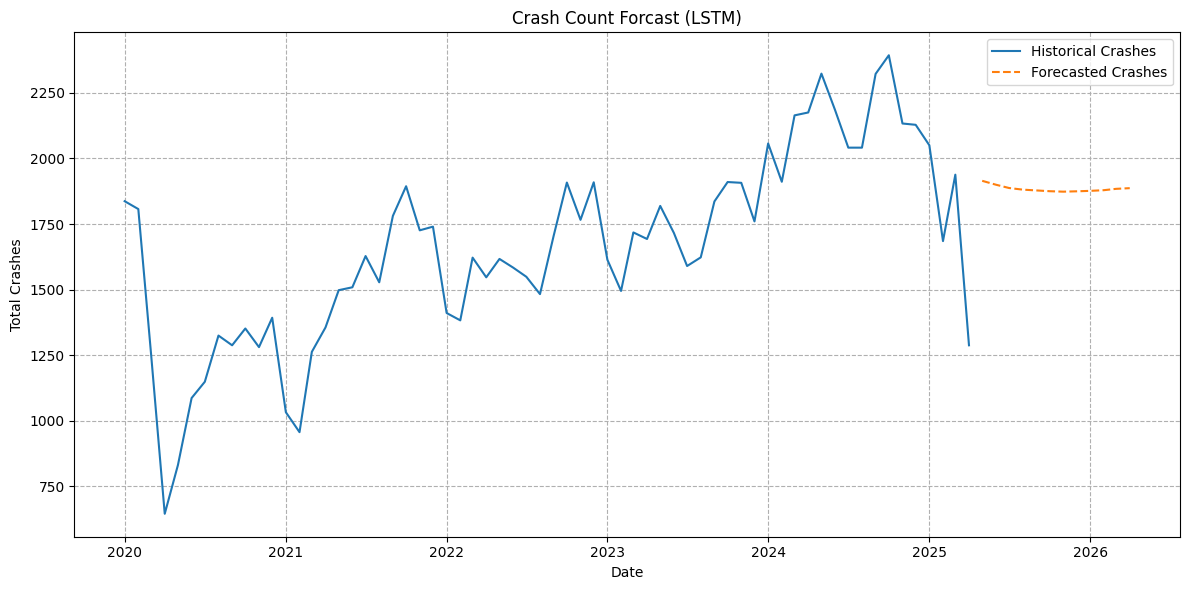

In [12]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(monthly_crashes.index, monthly_crashes['crashes'], label='Historical Crashes')
plt.plot(forecast_df.index, forecast_df['predicted_crashes'], label='Forecasted Crashes', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Total Crashes')
plt.title('Crash Count Forcast (LSTM)')
plt.legend()
plt.grid(True,linestyle='--')
plt.tight_layout()
plt.show()